# Estimating Gentrification using Street View Images and Embeddings

This script (initially produced by ChatGPT) does the following (_this was my query_):
 - Read a spatial boundary file (that I will hard code)
 - Obtain the road network (from OSM?) for that area
 - Generate sample points on the road network roughly X meters apart
 - At each sample point, download the most recent street images for that location (either a single 360 degree view of a few smaller images). Use whichever API service is the most appropriate for obtaining the images. Importantly please record the date that the image was taken.
 - For each image, calculate an embedding using an appropriate foundation model (one that has been pre-trained to distinguish street environments specifically). Please use Hugging Face libraries.
 - If necessary, calculate the mean embedding for each point (is this the best way to calculate a single embedding for a point represented by multiple images?)
 - Now, for each sampled point there will be a dataframe with information about the point and its embedding. Read another polygon spatial data file, that I will provide, which contains area-level estimates of gentrification.
 - Use point-in-polygon to get the gentrification for each point.
 - Use cross-validation to train a couple of ML models (probaly random forest, linear regression and a neural network) to estimate gentrification from the embedding vectors
 - Choose the best model and parameter configuration and test this model on some held-out data.

## Configuration and library loading

In [1]:
import os
os.environ["HF_HOME"] = "/nfs/a319/gy17m2a/scratch/hf_cache"
import random
import pickle
import geopandas as gpd
from shapely.geometry import Point, LineString
import numpy as np
import osmnx as ox
import torch
from PIL import Image
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm
from scipy.stats import entropy
import clip
import pandas as pd

# # Hugging Face Transformers for image embedding
from transformers import AutoImageProcessor, AutoModel, ViTModel, ViTImageProcessor, ViTConfig

# # ----------------- Configuration -----------------
# #np.random.seed(42)
# density_per_km = 0.3  # number of points to sample per km of road
# #density_per_km = 0.1  # VERY FEW WHILE TESTING
DOWNLOAD_IMAGES = False  # If false then don't download any images, just load those that have been cached

data_dir = os.path.join("../../data/embeddings/")
boundary_file = os.path.join(data_dir, "greater_manchester_lsoas.geojson")  # Path to boundary polygon file
lsoas_file = os.path.join("../../data/SpatialData/", "LSOAs_2021", "LSOA_2021_EW_BSC_V4.shp")
n_directions = 4         # number of street view images per point (e.g., 4 cardinal directions)

## Data Loading

In [2]:
# --- Load neighbourhood polygons and dissolve to one study-area boundary ---
boundary_neighs = gpd.read_file(boundary_file)
# Make sure we're in WGS84 (lat/lon) for OSM and APIs
boundary_neighs = boundary_neighs.to_crs(epsg=4326)
# Dissolve: merge all geometries into one polygon (MultiPolygon possible)
boundary_polygon = boundary_neighs.union_all()  # shapely (multi)polygon
boundary_gdf = gpd.GeoDataFrame(data={'name': ['study_area']},
    geometry=[boundary_polygon], crs=boundary_neighs.crs)
print("Merged neighbourhoods into single study-area boundary.")
print("Bounds:", boundary_polygon.bounds)
# boundary_gdf.plot(color='lightblue', edgecolor='black')

Merged neighbourhoods into single study-area boundary.
Bounds: (-2.73052481406758, 53.3281053809015, -1.90962093258169, 53.6857339236763)


## Read the LSOA boundary data

(later it will be joined to the Greater Manchester Gentrification Index and IMD)

In [3]:
lsoas =  gpd.read_file(lsoas_file)
manc_lads = ['Manchester', 'Rochdale', 'Bolton', 'Bury', 'Wigan', 'Oldham',  'Trafford', 'Salford', 'Tameside', 'Stockport']
manc_lads_pattern = '|'.join(manc_lads)
gm_lsoa=lsoas[lsoas['LSOA21NM'].str.contains(manc_lads_pattern)]
gm_lsoa = gm_lsoa.to_crs(epsg=4326)
# gm_lsoa.plot()

### Load list of sample points

In [4]:
# Cache file for the entire points data with embeddings (images are stored separately)
DEBUG = False
points_data_cache = data_dir + "sample_points_cache/points_data_cache_with_embeddings.pkl"

# -----------------------------------------------------------
# Load existing cache so we can *append* new sample points
# -----------------------------------------------------------
if os.path.isfile(points_data_cache):
    print("Loading cached point data …")
    with open(points_data_cache, "rb") as f:
        point_records = pickle.load(f)
    existing_coords = {(rec["latitude"], rec["longitude"]) for rec in point_records}
    next_id = max(rec["point_id"] for rec in point_records) + 1
else:
    point_records = []
    existing_coords = set()
    next_id = 0

print(f"Cache currently has {len(point_records)} points.")
added_this_run = 0

Loading cached point data …
Cache currently has 18897 points.


### Map of the full sample (cache + any others just downlaoded)

## Compute the Embeddings

(Note: would like to use Places365 but not available in Hugging Face yet, so using ViT base model instead)

In [5]:
# # ------------------------------
# # 1. Load CLIP
# # ------------------------------
# device = "cpu"
# model, preprocess = clip.load("ViT-B/32", device=device)

# # ------------------------------
# # 2. Define categories
# # ------------------------------
# categories = [
#     "a photo taken indoors, inside a building or a car",
#     "a photo primarily of a terraced house",
#     "a photo primarily of a detached or semi detached house",
#     "a photo primarily of a road",
#     "a photo of a shop",
#     "a photo dominated by the outside of a car",
#     "a photo of an industrial building",
#     "a photo of wasteland, empty space",
#     "a photo of nice green space, e.g. parks, gardens, nice trees and flowers"]

# text_tokens = clip.tokenize(categories).to(device)

# with torch.no_grad():
#     text_features = model.encode_text(text_tokens)
#     text_features /= text_features.norm(dim=-1, keepdim=True)  # normalize once


# # ------------------------------
# # 3. CLIP embedding + scoring
# # ------------------------------
# def embed_and_score_clip(img_path):
#     """Return CLIP embedding (512d) + category similarity scores."""
#     img = Image.open(img_path).convert("RGB")
#     image_tensor = preprocess(img).unsqueeze(0).to(device)

#     with torch.no_grad():
#         image_feat = model.encode_image(image_tensor)
#         image_feat /= image_feat.norm(dim=-1, keepdim=True)  # normalize for cosine sim

#         # similarities → shape (1, num_categories)
#         sims = (image_feat @ text_features.T).softmax(dim=-1)

#     return (
#         image_feat.cpu().numpy()[0],      # 512-dim embedding
#         sims.cpu().numpy()[0]             # category probs (len 9)
#     )


# # ------------------------------
# # 4. Dummy fields for compatibility
# # ------------------------------
# def empty_attention_stats():
#     return {"mean": None, "std": None, "entropy": None, "max_y": None, "max_x": None}


# # ------------------------------
# # 5. Embed + score all images
# # ------------------------------
# for rec in tqdm(point_records, desc="Embedding points", unit="point"):

#     rec["embedding"] = []
#     rec["category_scores"] = []      # <—— NEW
#     rec["attn_stats"] = []           # empty placeholders
#     rec["heatmap_paths"] = []        # always None

#     for img_path in rec["image_files"]:
#         img_path = (
#             img_path.replace("airbnb-manchester/", "embeddings/")
#                     .replace("../", "../../")
#         )

#         if not os.path.exists(img_path):
#             continue

#         try:
#             embedding, scores = embed_and_score_clip(img_path)

#             rec["embedding"].append(embedding)
#             rec["category_scores"].append(scores)
#             rec["attn_stats"].append(empty_attention_stats())
#             rec["heatmap_paths"].append(None)

#         except Exception as e:
#             tqdm.write(f"⚠️ Error processing {img_path}: {e}")


# # ------------------------------
# # 6. Save cache
# # ------------------------------
# output_file = (data_dir + "sample_points_cache/points_data_cache_with_CLIP_embeddings_and_scores.pkl")

# with open(output_file, "wb") as f:
#     pickle.dump(point_records, f)

# print(f"\n💾 Saved embeddings + category scores for {len(point_records)} points.")


In [7]:
# # Check all records have an embeding
# invalid_records = [rec for rec in point_records if rec.get('embedding') is None]
# assert len(invalid_records)==0, f"Found {len(invalid_records)} invalid points"

In [8]:
# ------------------------------
# 1. Load CLIP
# ------------------------------
device = "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

# ------------------------------
# 2. Define categories
# ------------------------------
categories = [
    "a photo taken indoors, inside a building or a car",
    "a photo primarily of a terraced house",
    "a photo primarily of a detached or semi detached house",
    "a photo primarily of a road",
    "a photo of a shop",
    "a photo dominated by the outside of a car",
    "a photo of an industrial building",
    "a photo of wasteland, empty space",
    "a photo of nice green space, e.g. parks, gardens, nice trees and flowers"
]

text_tokens = clip.tokenize(categories).to(device)

# ---- Compute text embedding ONCE ----
with torch.no_grad():
    text_features = model.encode_text(text_tokens)
    text_features /= text_features.norm(dim=-1, keepdim=True)
    text_features = text_features.cpu()     # STABLE
 

def embed_and_score_clip(img_path, temperature=0.07):
    """
    Recommended hybrid: 
    - Text is normalised once (correct)
    - Image is NOT normalised (restores separation)
    - Temperature sharpens scores
    """
    img = Image.open(img_path).convert("RGB")
    image_tensor = preprocess(img).unsqueeze(0).to(device)

    with torch.no_grad():
        image_feat = model.encode_image(image_tensor)  # no normalisation

        txt = text_features.to(device)                 # normalised text
        logits = (image_feat @ txt.T) / temperature    # sharpen
        sims = logits.softmax(dim=-1)

    return image_feat.cpu().numpy()[0], sims.cpu().numpy()[0]


# ------------------------------
# 4. Placeholder stats
# ------------------------------
def empty_attention_stats():
    return {"mean": None, "std": None, "entropy": None, "max_y": None, "max_x": None}


# ------------------------------
# 5. Embed all images
# ------------------------------
for rec in tqdm(point_records, desc="Embedding points", unit="point"):

    rec["embedding"] = []
    rec["category_scores"] = []
    rec["attn_stats"] = []
    rec["heatmap_paths"] = []

    for img_path in rec["image_files"]:

        # Use ORIGINAL images
        img_path = img_path.replace("airbnb-manchester/", "embeddings/").replace("../", "../../")

        try:
            embedding, scores = embed_and_score_clip(img_path)

            rec["embedding"].append(embedding)
            rec["category_scores"].append(scores)
            rec["attn_stats"].append(empty_attention_stats())
            rec["heatmap_paths"].append(None)

        except Exception as e:
            tqdm.write(f"⚠️ Error: {e}")

output_file = (data_dir + "sample_points_cache/points_data_cache_with_CLIP_embeddings_and_scores_test.pkl")

with open(output_file, "wb") as f:
    pickle.dump(point_records, f)

print(f"\n💾 Saved embeddings + category scores for {len(point_records)} points.")

Embedding points:  48%|███████████████████████████████████████████████████▊                                                       | 9159/18897 [26:35<27:58,  5.80point/s]

⚠️ Error: [Errno 2] No such file or directory: '../../data/embeddings/street_images/point9285_heading90.jpg'


Embedding points:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 18666/18897 [53:04<00:34,  6.78point/s]

⚠️ Error: [Errno 2] No such file or directory: '../../data/embeddings/street_images/point18959_heading270.jpg'


Embedding points: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 18897/18897 [53:44<00:00,  5.86point/s]



💾 Saved embeddings + category scores for 18897 points.


In [ ]:
# --- Tokenize once ---
text_tokens = clip.tokenize(categories).to(device)

for img_path in tqdm(expanded_gdf['image_files'][:5000], desc="Processing images"):
    adj_path = img_path.replace("airbnb-manchester/", "embeddings/").replace("../", "../../")
    try:
        image = preprocess(Image.open(adj_path)).unsqueeze(0).to(device)
    except:
        continue
    
    with torch.no_grad():
        img_feat = model.encode_image(image)
        txt_feat = model.encode_text(text_tokens)
        sims = (img_feat @ txt_feat.T).softmax(dim=-1)
        category_probs.append(sims.cpu().numpy()[0])
        image_paths_adj.append(adj_path)

### Old

In [23]:
data_dir = os.path.join("../../data/embeddings/")
lsoas_file = os.path.join("../../data/SpatialData/", "LSOAs_2021", "LSOA_2021_EW_BSC_V4.shp")
points_data_cache = data_dir + "sample_points_cache/points_data_cache_with_embeddings_and_attn_stats_new.pkl"
with open(points_data_cache, "rb") as f:
    point_records = pickle.load(f)

In [25]:
point_coords = [Point(rec['longitude'], rec['latitude']) for rec in point_records]
points_labels_gdf = gpd.GeoDataFrame(point_records, geometry=point_coords, crs="EPSG:4326")

In [28]:
expanded_rows = []

for _, row in points_labels_gdf.iterrows():
    embeddings = row['embeddings']      # list of 4 embeddings
    images = row['image_files']        # list of 4 image paths

    # Skip if lengths don't match
    if len(embeddings) != len(images):
        print(f"Skipping row {row.name}: {len(embeddings)} embeddings, {len(images)} images")
        continue

    for emb, img in zip(embeddings, images):
        new_row = row.to_dict()        # copy all other columns
        new_row['embeddings'] = emb     # single embedding
        new_row['image_files'] = img    # single image
        expanded_rows.append(new_row)

# Create new DataFrame
expanded_gdf = pd.DataFrame(expanded_rows)
print(f"Original rows: {len(points_labels_gdf)}, Expanded rows: {len(expanded_gdf)}")
expanded_gdf = pd.DataFrame(expanded_rows)

Skipping row 9158: 3 embeddings, 4 images
Skipping row 12091: 3 embeddings, 4 images
Skipping row 18664: 3 embeddings, 4 images
Original rows: 18897, Expanded rows: 75576


In [33]:
device = "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

# --- Define categories ---
category_names = ["indoor", "terraced house","semi-detached house", "road", "shop", "car", "industrial", "wasteland", "greenery"]  # For plotting

# --- Tokenize once ---
text_tokens = clip.tokenize(categories).to(device)

# --- Compute category probabilities ---
image_paths_adj = []
category_probs = []

for img_path in tqdm(expanded_gdf['image_files'][:5000], desc="Processing images"):
    adj_path = img_path.replace("airbnb-manchester/", "embeddings/").replace("../", "../../")
    try:
        image = preprocess(Image.open(adj_path)).unsqueeze(0).to(device)
    except:
        continue
    
    with torch.no_grad():
        img_feat = model.encode_image(image)
        txt_feat = model.encode_text(text_tokens)
        sims = (img_feat @ txt_feat.T).softmax(dim=-1)
        category_probs.append(sims.cpu().numpy()[0])
        image_paths_adj.append(adj_path)

category_probs = np.array(category_probs)

Processing images: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [11:08<00:00,  7.48it/s]


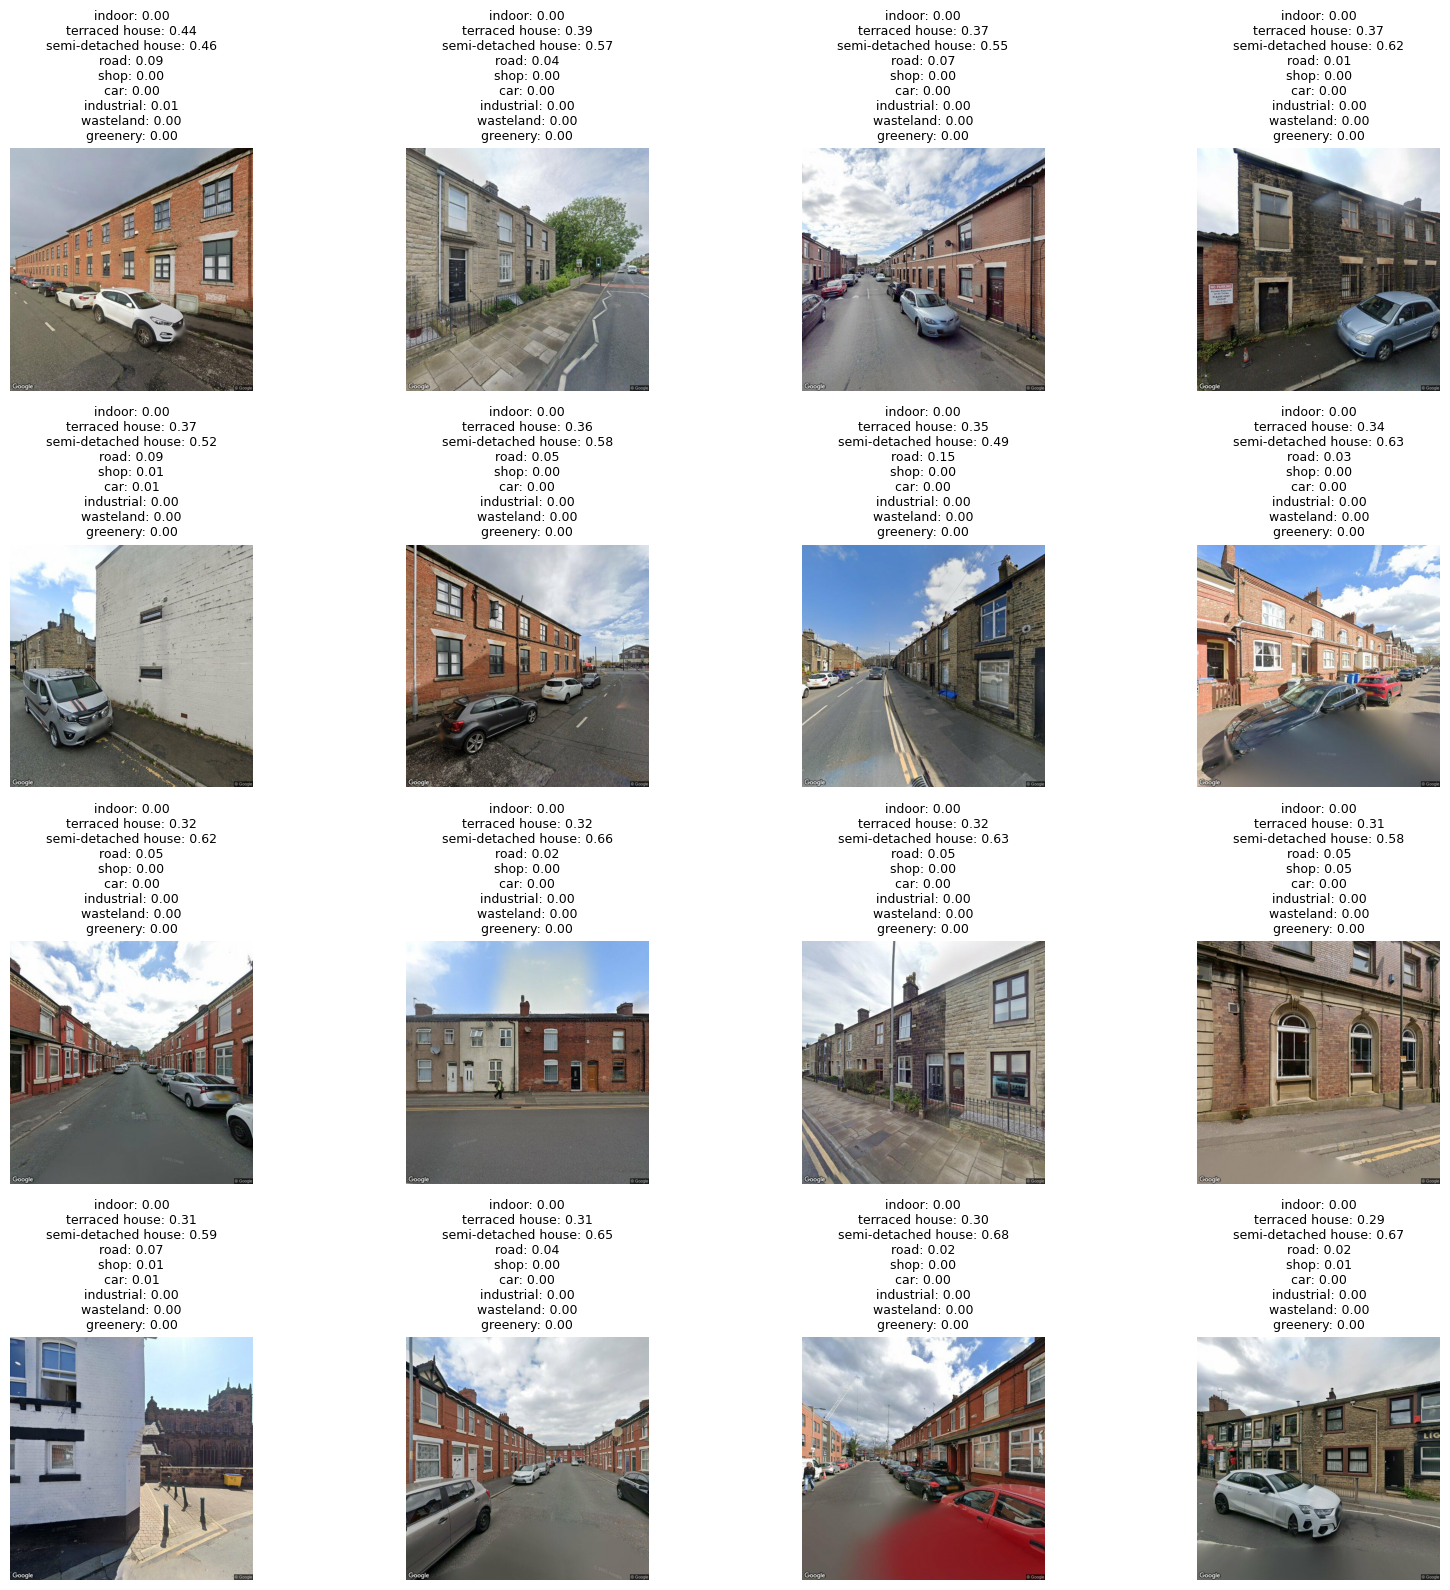

In [38]:
# --- Plot function ---
def plot_images_with_scores(image_paths, category_probs, category_names, n_images, n_cols=3, sort_by=None):
    """
    Plots images in a grid with category probabilities above each image.
    """
    if sort_by is not None:
        sort_idx = np.argsort(category_probs[:, category_names.index(sort_by)])[::-1]
        image_paths = [image_paths[i] for i in sort_idx]
        category_probs = category_probs[sort_idx]
    
    #n_images = len(image_paths)
    n_rows = math.ceil(n_images / n_cols)
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*4, n_rows*4))
    axs = axs.flatten()
    
    for i in range(n_images):
        try:
            img = Image.open(image_paths[i])
            axs[i].imshow(img)
        except:
            axs[i].axis('off')
            continue
        
        scores_text = "\n".join([
            f"{name}: {category_probs[i, idx]:.2f}" 
            for idx, name in enumerate(category_names)
        ])
        axs[i].set_title(scores_text, fontsize=9)
        axs[i].axis('off')
    
    # Turn off unused axes
    for j in range(n_images, len(axs)):
        axs[j].axis('off')
    
    plt.tight_layout()
    plt.show()

plot_images_with_scores(image_paths_adj, category_probs, category_names, n_images=16, n_cols=4, sort_by="terraced house")